# Spatial mapping with Tangram

This tutorial demonstrates how to use [Tangram](https://www.nature.com/articles/s41592-021-01264-7) ([original code](https://github.com/broadinstitute/Tangram/)) to map spatial transcriptomics data. Here, we follow the corresponding [tutorial](https://squidpy.readthedocs.io/en/stable/external_tutorials/tutorial_tangram.html) at Squidpy. We do not provide much explanation, and instead refer to the original tutorial.

In scvi-tools, the `"cells"` and `"constrained"` modes of Tangram are implemented. In the `"cells"` mode, the priors will need to be calculated manually. We show this below.

In [ ]:
!pip install --quiet scvi-colab
!pip install --quiet squidpy
from scvi_colab import install

install()

In [1]:
import matplotlib.pyplot as plt
import mudata
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import squidpy as sq
from scvi.external import Tangram

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [ ]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

In [1]:
# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 0
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## Load and preprocess data with squidpy

In [2]:
adata_sp = sq.datasets.visium_fluo_adata_crop("data/visium_fluo_adata_crop.h5ad")
adata_sp = adata_sp[
    adata_sp.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])
].copy()
img = sq.datasets.visium_fluo_image_crop("data/visium_fluo_image_crop.h5ad")

adata_sc = sq.datasets.sc_mouse_cortex("data/sc_mouse_cortex.h5ad")

sc.pp.filter_genes(adata_sp, min_cells=1)
sc.pp.filter_genes(adata_sc, min_cells=1)

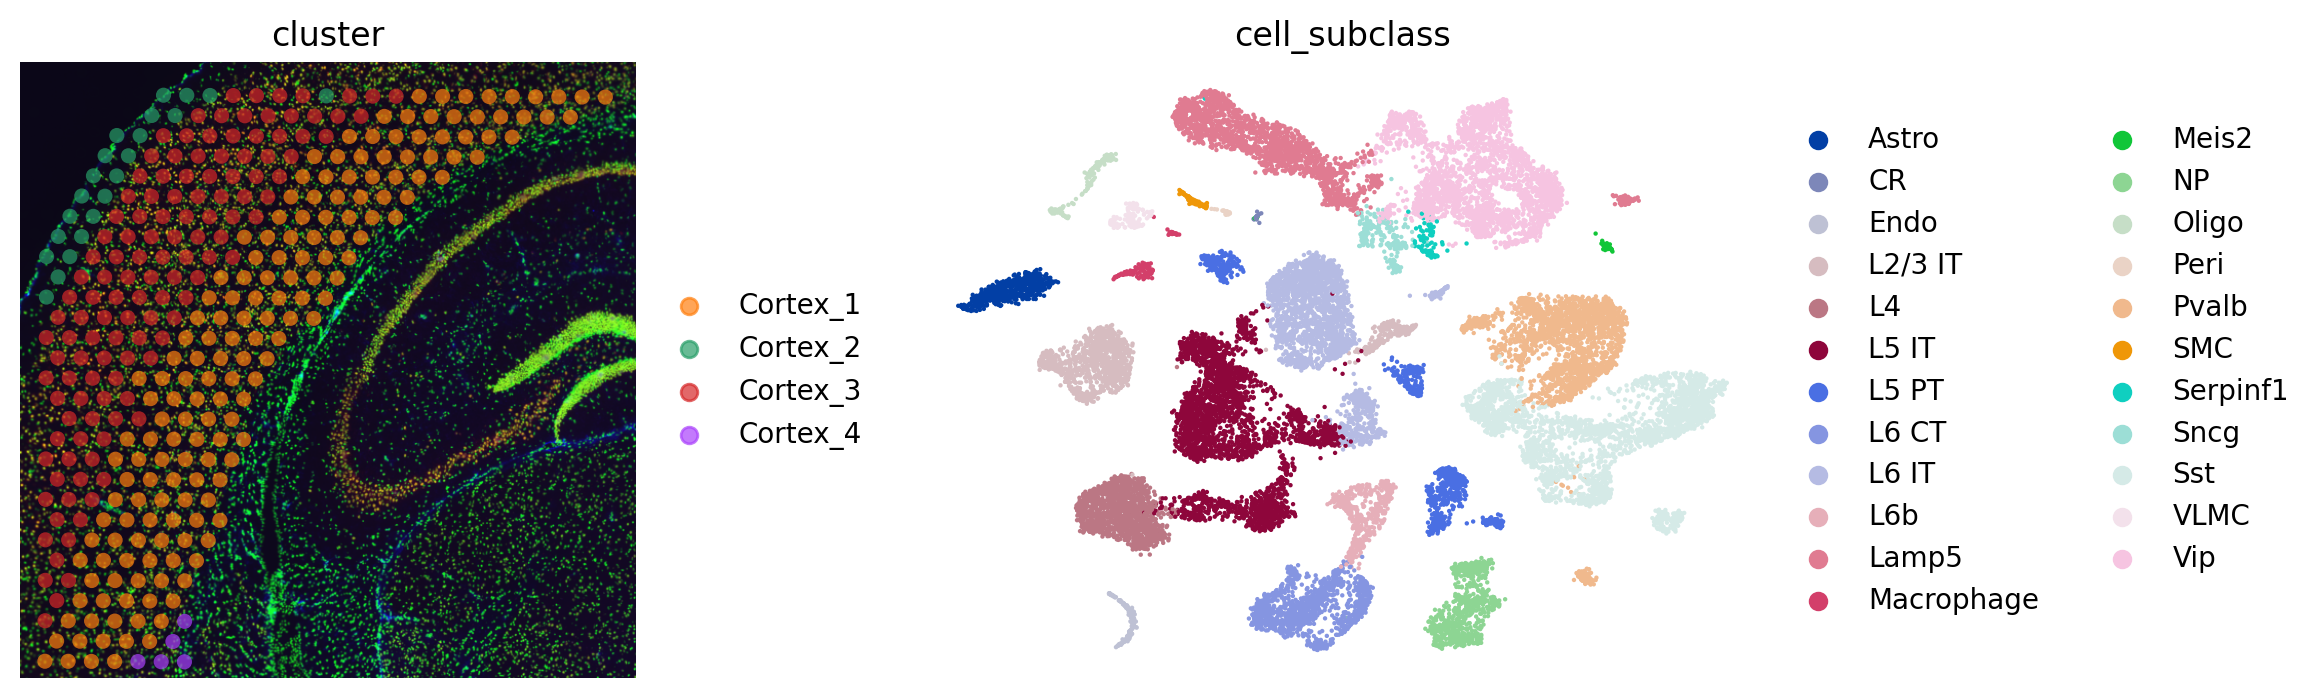

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sq.pl.spatial_scatter(adata_sp, color="cluster", alpha=0.7, frameon=False, ax=axs[0])
sc.pl.umap(adata_sc, color="cell_subclass", size=10, frameon=False, ax=axs[1])

In [4]:
mdata = mudata.MuData(
    {
        "sp": adata_sp,
        "sc": adata_sc,
    }
)

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/mudata/_core/mudata.py:449: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/mudata/_core/mudata.py:569: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/mudata/_core/mudata.py:569: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [5]:
sq.im.process(img=img, layer="image", method="smooth")
sq.im.segment(
    img=img,
    layer="image_smooth",
    method="watershed",
    channel=0,
)
# define image layer to use for segmentation
features_kwargs = {
    "segmentation": {
        "label_layer": "segmented_watershed",
        "props": ["label", "centroid"],
        "channels": [1, 2],
    }
}
# calculate segmentation features
sq.im.calculate_image_features(
    adata_sp,
    img,
    layer="image",
    key_added="image_features",
    features_kwargs=features_kwargs,
    features="segmentation",
    mask_circle=True,
)

  0%|          | 0/324 [00:00<?, ?/s]

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/squidpy/im/_feature_mixin.py:346: RuntimeWarning: invalid value encountered in true_divide
  y = (y - np.min(y)) / (np.max(y) - np.min(y))
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/squidpy/im/_feature_mixin.py:347: RuntimeWarning: invalid value encountered in true_divide
  x = (x - np.min(x)) / (np.max(x) - np.min(x))
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/squidpy/im/_feature_mixin.py:346: RuntimeWarning: invalid value encountered in true_divide
  y = (y - np.min(y)) / (np.max(y) - np.min(y))
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/squidpy/im/_feature_mixin.py:347: RuntimeWarning: invalid value encountered in true_divide
  x = (x - np.min(x)) / (np.max(x) - np.min(x))
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/squidpy/im/_feature_mixin.py:346: RuntimeWarning: invalid value encountered in true_divid

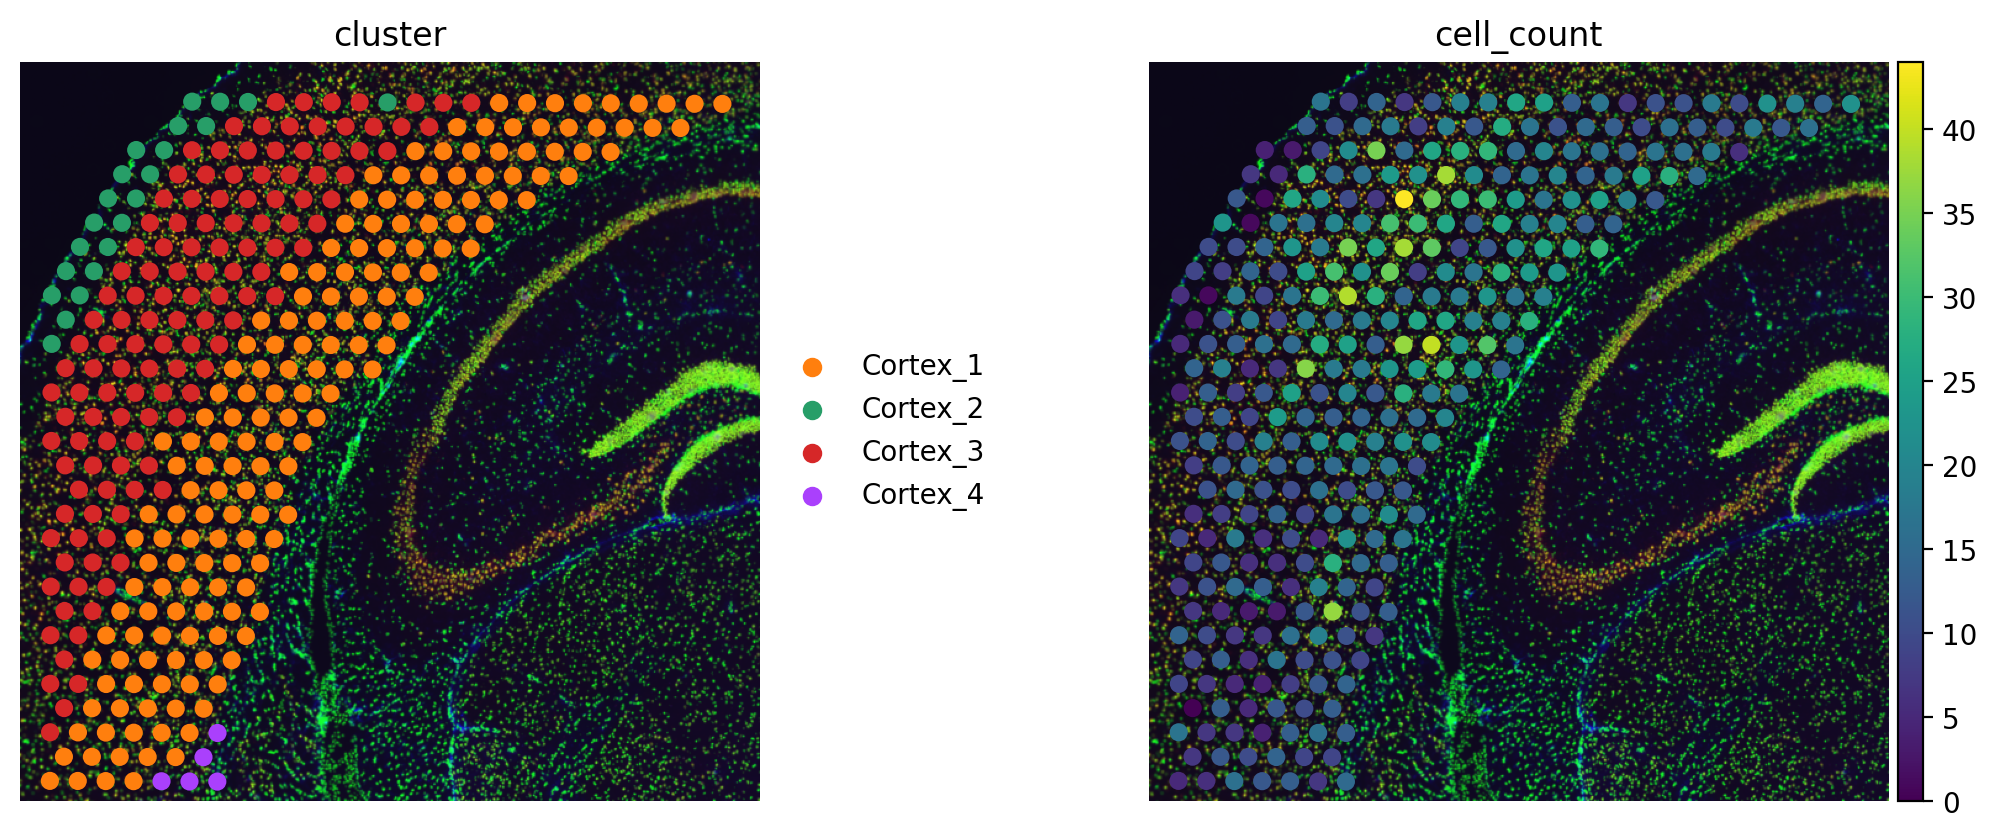

In [6]:
adata_sp.obs["cell_count"] = adata_sp.obsm["image_features"]["segmentation_label"]
sq.pl.spatial_scatter(
    adata_sp, color=["cluster", "cell_count"], frameon=False, wspace=0.01
)

In [7]:
sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass", use_raw=False)

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/scanpy/tools/_rank_genes_g

### Find genes for mapping

In [8]:
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
genes_sc = np.unique(markers_df.melt().value.values)
genes_st = adata_sp.var_names.values
genes = list(set(genes_sc).intersection(set(genes_st)))
len(genes)

1280

### Add training objects to mudata

Here we compute all the density priors we need to run Tangram.

In [9]:
target_count = adata_sp.obs.cell_count.sum()
adata_sp.obs["density_prior"] = np.asarray(adata_sp.obs.cell_count) / target_count
rna_count_per_spot = np.asarray(adata_sp.X.sum(axis=1)).squeeze()
adata_sp.obs["rna_count_based_density"] = rna_count_per_spot / np.sum(
    rna_count_per_spot
)
adata_sp.obs["uniform_density"] = np.ones(adata_sp.X.shape[0]) / adata_sp.X.shape[0]
mdata.mod["sp_train"] = mdata.mod["sp"][:, genes].copy()
mdata.mod["sc_train"] = mdata.mod["sc"][:, genes].copy()
mdata.update()

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/mudata/_core/mudata.py:449: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/mudata/_core/mudata.py:569: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/mudata/_core/mudata.py:569: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


## Run Tangram

Here we run the constrained mode; however, we could have set `constrained=False`, `target_count=None`, and `density_prior_key="rna_count_based_density"` to recover Tangram's `"cells"` mode.

In [10]:
Tangram.setup_mudata(
    mdata,
    density_prior_key="density_prior",
    modalities={
        "density_prior_key": "sp_train",
        "sc_layer": "sc_train",
        "sp_layer": "sp_train",
    },
)
model = Tangram(mdata, constrained=True, target_count=target_count)
model.train()
mapper = model.get_mapper_matrix()
mdata.mod["sc"].obsm["tangram_mapper"] = mapper
labels = mdata.mod["sc"].obs.cell_subclass
mdata.mod["sp"].obsm["tangram_ct_pred"] = model.project_cell_annotations(
    mdata.mod["sc"], mdata.mod["sp"], mapper, labels
)
mdata.mod["sp_sc_projection"] = model.project_genes(
    mdata.mod["sc"], mdata.mod["sp"], mapper
)
adata_sp.obs = adata_sp.obs.join(adata_sp.obsm["tangram_ct_pred"])

INFO     Jax module moved to GPU. Note: Pytorch lightning will show GPU is not being used for the Trainer.         
Training:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/flax/core/scope.py:740: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/flax/core/scope.py:741: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)


Training... Loss: 82.1288070678711: 100%|██████████| 1000/1000 [00:03<00:00, 253.42it/s] 


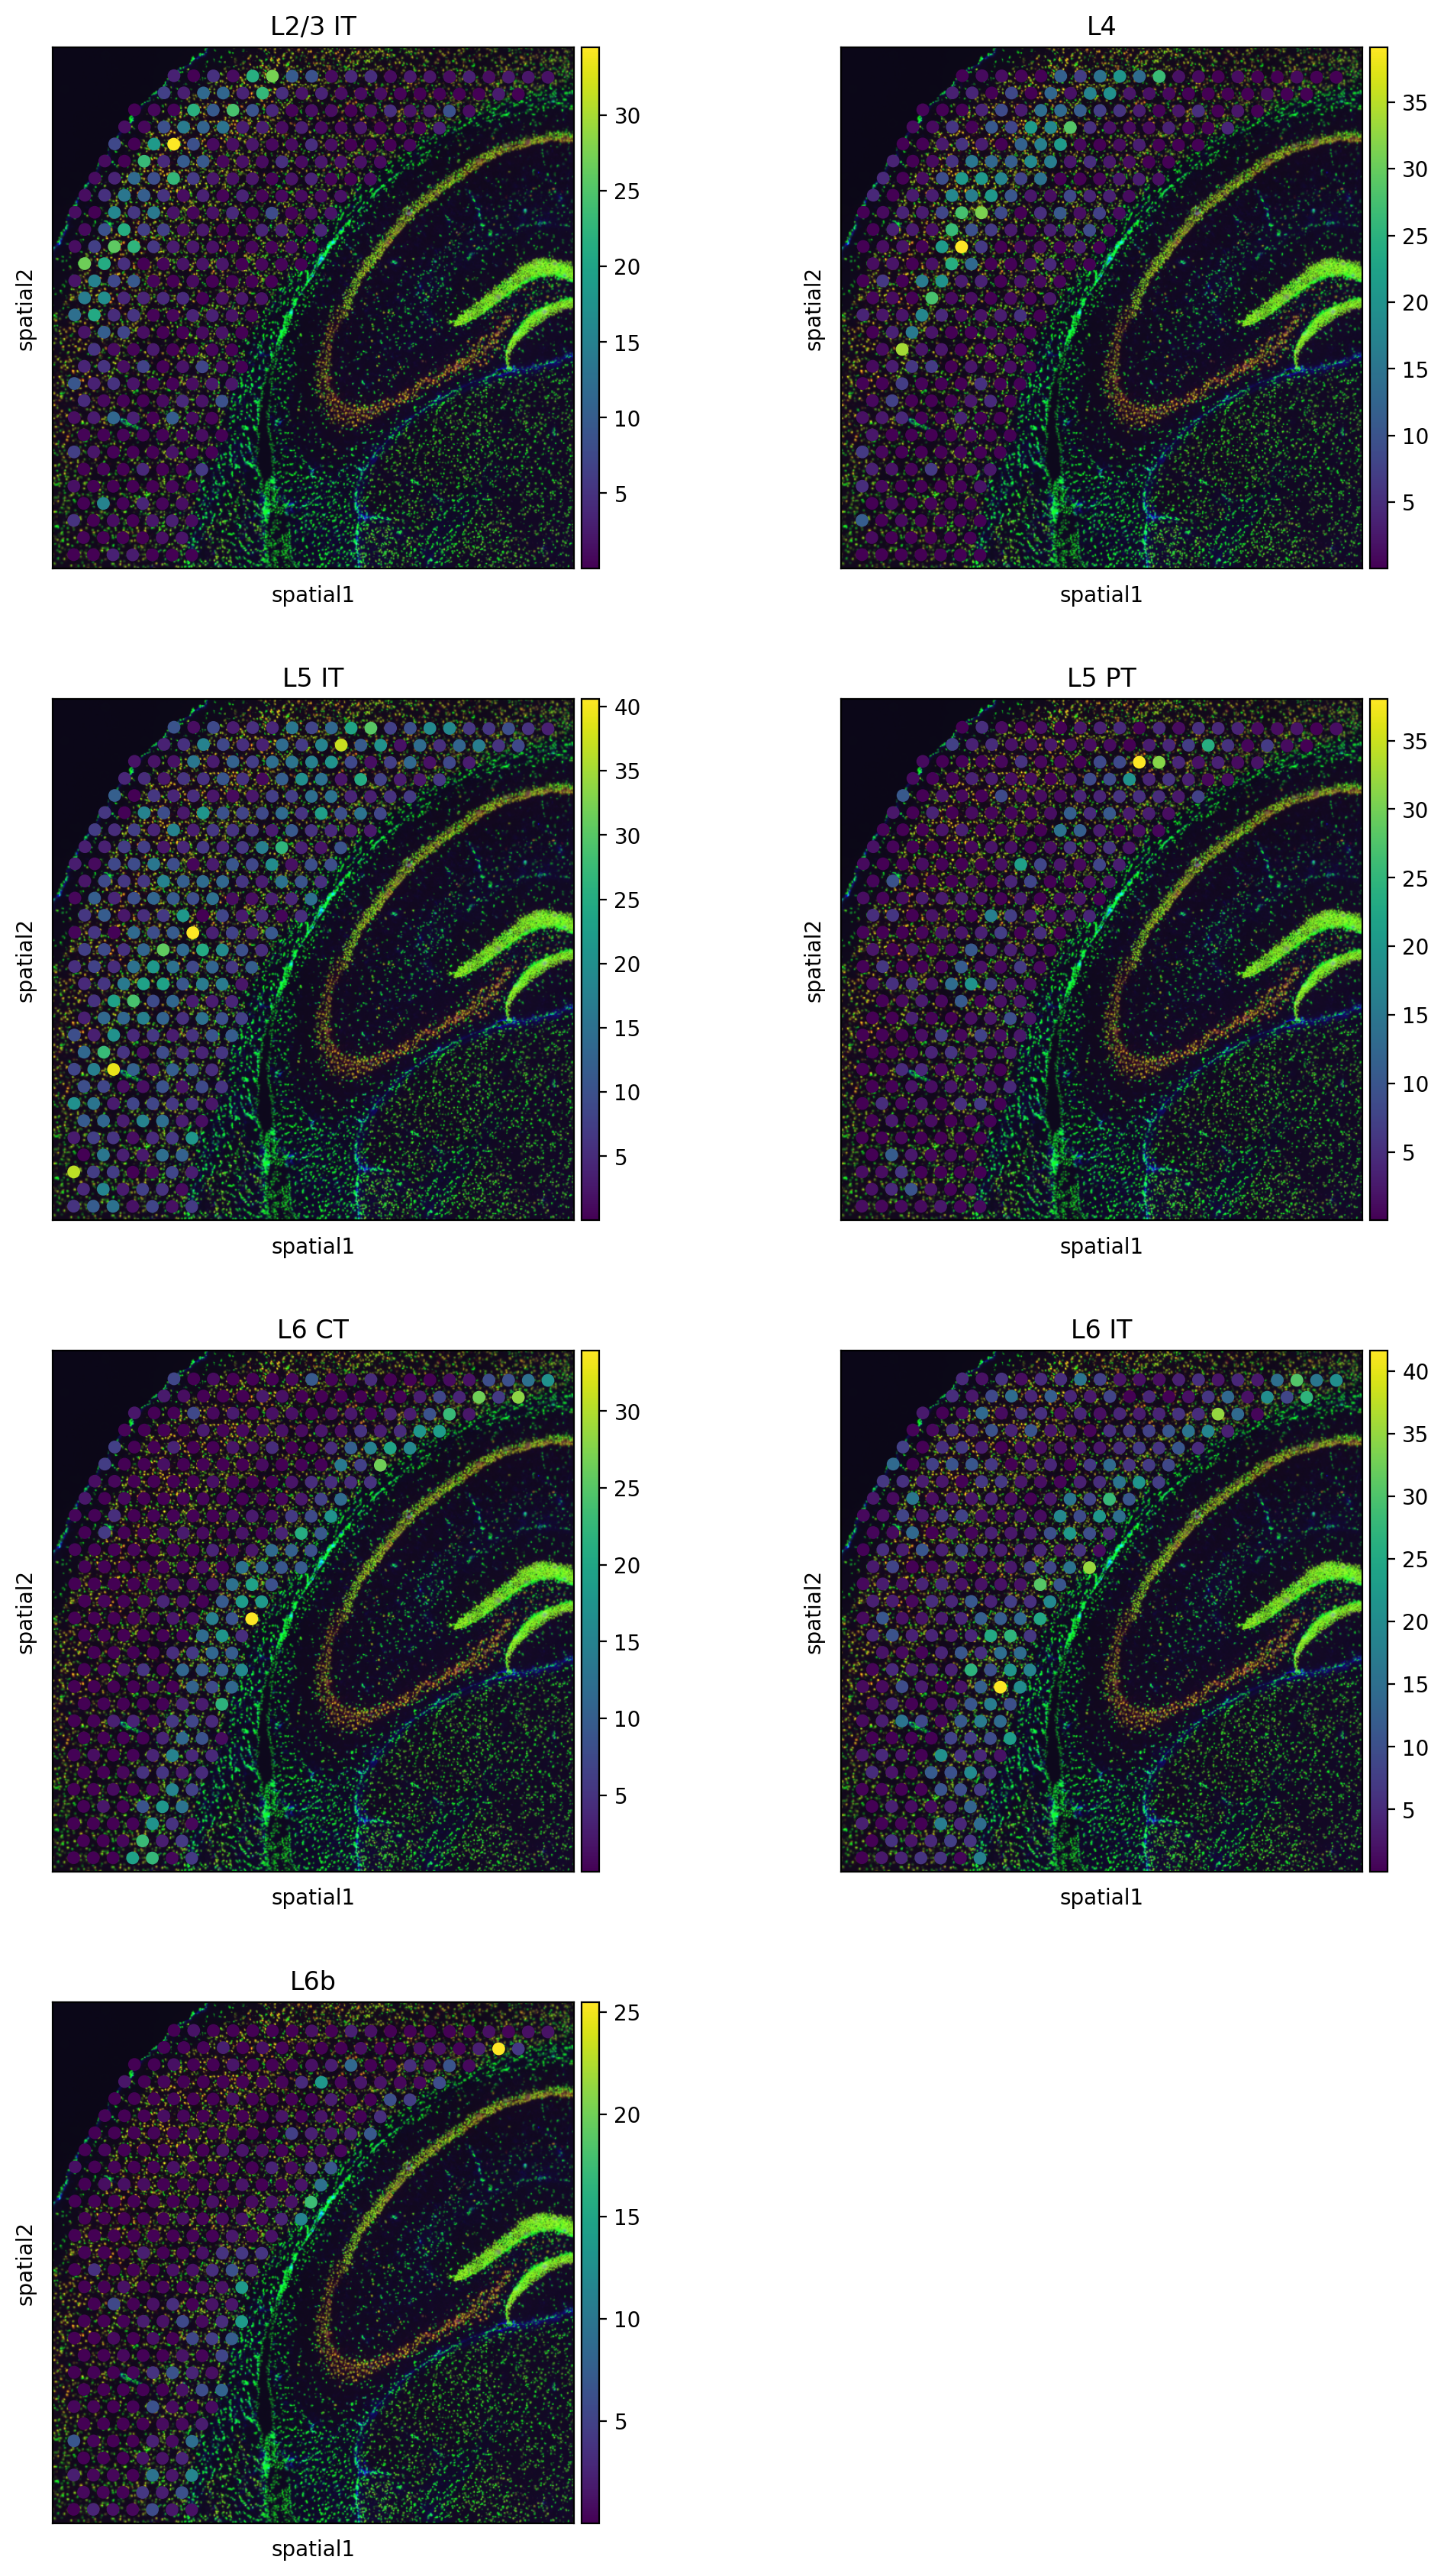

In [11]:
sq.pl.spatial_scatter(
    adata_sp,
    color=["L2/3 IT", "L4", "L5 IT", "L5 PT", "L6 CT", "L6 IT", "L6b"],
    wspace=0.01,
    ncols=2,
)